In [1]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain.tools import tool
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel, Field
from rich.console import Console
from rich.markdown import Markdown

load_dotenv()

True

In [11]:
llm = ChatOpenAI(model="openai/gpt-5-nano", temperature=0, max_tokens=4096 * 2)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                   model_kwargs={"local_files_only": True, "device": "cpu"})

In [22]:
class ScratchpadState(MessagesState):
    scratchpad: str = Field(description="The scratchpad for storing notes")


@tool
class WriteToScratchpad(BaseModel):
    notes: str = Field(description="Notes to save to the scratchpad")


@tool
class ReadFromScratchpad(BaseModel):
    reasoning: str = Field(description="Reasoning for reading from the scratchpad")


search_tool = TavilySearch(
        max_results=3, topic="general"
)

tools = [ReadFromScratchpad, WriteToScratchpad, search_tool]

tool_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

scratchpad_prompt = """You are an advanced research assistant equipped with web search capabilities and a persistent scratchpad system for systematic knowledge management.

## Core Research Methodology:

### Phase 1: Foundation & Planning
- **Scratchpad Review**: Begin by examining your scratchpad for existing relevant research, insights, or partial work that could inform your current task
- **Context Assessment**: Evaluate what you already know versus what needs to be discovered
- **Strategic Planning**: Develop a comprehensive, structured research plan with clear objectives, key questions, and search strategies
- **Documentation**: Record your research plan, hypotheses, and initial thoughts in the scratchpad

### Phase 2: Active Research & Discovery
- **Targeted Searching**: Execute systematic web searches aligned with your research plan
- **Real-time Documentation**: After each search, immediately update your scratchpad with:
  - New findings and data points
  - Source credibility assessments
  - Connections to previous research
  - Emerging patterns or contradictions
  - Gaps that require further investigation

### Phase 3: Analysis & Synthesis
- **Cross-referencing**: Compare findings across sources and previous research
- **Critical Evaluation**: Assess information quality, bias, and reliability
- **Pattern Recognition**: Identify trends, relationships, and insights
- **Continuous Updates**: Refine your understanding and update scratchpad accordingly

### Phase 4: Iteration & Refinement
- **Gap Analysis**: Identify remaining questions or weak evidence
- **Follow-up Research**: Conduct additional targeted searches as needed
- **Knowledge Integration**: Synthesize new information with existing research
- **Quality Assurance**: Verify key facts and resolve contradictions

### Phase 5: Completion & Delivery
- **Comprehensive Response**: Provide thorough, well-supported answers based on accumulated research
- **Source Documentation**: Include proper attribution and evidence
- **Future-Ready Notes**: Ensure scratchpad contains organized, reusable research for potential follow-up questions

## Available Research Tools:
- **WriteToScratchpad**: Persistent storage for research plans, findings, insights, and progress tracking
- **ReadFromScratchpad**: Retrieval of previous research work, notes, and accumulated knowledge
- **TavilySearch**: Web search for current information, data, and diverse perspectives

## Quality Standards:
- Maintain organized, chronological notes with clear categorization
- Build systematically upon previous research rather than starting from scratch
- Prioritize accuracy, comprehensiveness, and critical analysis
- Document both confirmatory and contradictory evidence
- Create a knowledge base that supports both immediate needs and future research

Your scratchpad is your research memory - use it strategically to become more effective with each interaction."""


def llm_call(state: ScratchpadState) -> dict:
    return {
        "messages": [
            llm_with_tools.invoke(
                    [SystemMessage(content=scratchpad_prompt)] + state["messages"]
            )
        ]
    }


def tool_node(state: ScratchpadState) -> dict:
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tool_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        if tool_call["name"] == "WriteToScratchpad":
            notes = observation.notes
            result.append(ToolMessage(content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result, "scratchpad": notes}

        elif tool_call["name"] == "ReadFromScratchpad":
            # Retrieve notes from the scratchpad
            notes = state.get("scratchpad", "")
            result.append(ToolMessage(content=f"Notes from scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result}

        elif tool_call["name"] == "tavily_search":
            # Write search tool observation to messages
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            update = {"messages": result}
    return update



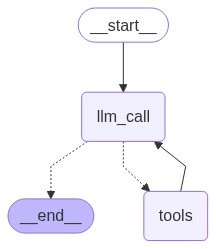

In [23]:
agent_builder = StateGraph(ScratchpadState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node)
agent_builder.set_entry_point("llm_call")
agent_builder.add_edge("tools", "llm_call")
agent_builder.add_conditional_edges("llm_call", tools_condition, {
    "tools": "tools",
    END: END
})

agent = agent_builder.compile()
# Display the workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [28]:
# Research request
from langchain_core.messages import HumanMessage

query = "Compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy."

state = agent.invoke({"messages": [HumanMessage(content=query)]})

from utils import format_messages

format_messages(state['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy.             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding rounds 2021 2022 2023 2024 press release',                       │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.cfs.energy/news-and-media/commonwealth-fusion-systems-closes-1-8-billion-series-b-round/',         │
│ 'title': 'Commonwealth Fusion Systems Raises $1.8 Billion in Funding to ...', 'content': 'Commonwealth Fusion   │
│ Systems (CFS) announced it has closed on more than $1.8 billion in Series B funding to commercialize fusion     │
│ energy. This includes capital to construct, commission, and operate SPARC, the world’s first commercially       │
│ relevant net energy fusion machine. In addition, it will enable the company to begin work on ARC, the first     │
│ commercial fusion power plant, which includes developing support technologies, advancing the design,            │
│ identifying the site, and assembling the partners and [...] "From the very beginning, we have strongly believed │
│ that this technology could be breakthrough on the path to producing net zero energy. Magnetic fusion can        │
│ significantly increase the pace at which the world cuts its carbon emissions. We have worked with the CFS team  │
│ for these last years because we recognized that their work could transform the energy landscape. Thanks to      │
│ their monumental breakthroughs, a commercial fusion plant is soon going to be within reach. We’re proud to be   │
│ backing the [...] “We’ve followed developments in fusion energy for years, anxious to find a practical approach │
│ that can achieve net positive energy generation. The team at CFS has finally done it, breaking through          │
│ longstanding technological barriers with an innovative design that promises to provide a safe, sustainable, and │
│ scalable source of clean fusion power. We are beyond excited to join Bob and his team at CFS to help power the  │
│ future of our planet,” said Randy Glein, partner, DFJ Growth.', 'score': 0.8488849, 'raw_content': None},       │
│ {'url': 'https://www.fusionenergybase.com/organizations/commonwealth-fusion-systems', 'title': 'Commonwealth    │
│ Fusion Systems (CFS)', 'content': 'AnnouncementSeries A\n\nFunding Received                                     │
│ (Nondilutive)\n==============================\n\n### September 27, 2024\n\nprogram                              │
│ CHADWICK\n\n$2,500,000\n\nFundersAdvanced Research Projects Agency-Energy (ARPA-E)\n\nAnnouncementCHADWICK:     │
│ Co-Optimization of an Integral, Layered Materials Solution for Compact Tokamak Vessels\n\n### August 8,         │
│ 2024\n\nprogram INFUSE\n\nFundersFusion Energy Sciences (FES)\n\nAnnouncementINFUSE: Elemental Analysis of      │
│ Fluoride Molten Salt Using Laser Induced Breakdown Spectroscopy (LIBS) [...] AnnouncementINFUSE: A modern       │
│ neutronics-modeling uncertainty methodology towards a future fusion neutronics handbook\n\n### January 17,      │
│ 2023\n\nprogram INFUSE\n\nFundersFusion Energy Sciences (FES)\n\nAnnouncementINFUSE: Oxide Dispersion           │
│ Strengthened Ferritic Steel Wire Feedstock Development for Large-Format Additive Manufacturing\n\n### June 15,  │
│ 2022\n\nprogram INFUSE\n\nFundersFusion Energy Sciences (FES) [...] AnnouncementINFUSE: Characterization of     │
│ Turbulent Transport and Confinement in ARC with STEP and CGYRO\n\n### June 15, 2022\n\nprogram                  │
│ INFUSE\n\nFundersFusion Energy Sciences (FES)\n\nAnnouncementINFUSE: Machine learning assisted prediction of    │
│ tungsten heavy alloy plasma facing component performance for fusion energy applications\n\n### June 15,         │
│ 2022\n\nprogram INFUSE\n\nFundersFusion Energy Sciences (FES)', 'score': 0.83742094, 'raw_content': None},      │
│ {'url':                                                

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems latest developments 2024 2025 SPARC MIT news', 'follow_up_questions':    │
│ None, 'answer': None, 'images': [], 'results': [{'url': 'https://cfs.energy/news-and-media/', 'title': 'Press', │
│ 'content': "Commonwealth Fusion Systems' second breakthrough superconducting technology handles mammoth pulses  │
│ of power.", 'score': 0.98571, 'raw_content': None}, {'url':                                                     │
│ 'https://news.mit.edu/2024/commonwealth-fusion-systems-unveils-worlds-first-fusion-power-plant-1217', 'title':  │
│ 'MIT spinout Commonwealth Fusion Systems unveils plans ...', 'content': 'The new fusion power plant, named ARC, │
│ is expected to come online in the early 2030s and generate about 400 megawatts of clean, carbon-free            │
│ electricity.', 'score': 0.98534, 'raw_content': None}, {'url': 'https://cfs.energy/devens-campus/updates/',     │
│ 'title': 'Devens Events & Updates - Commonwealth Fusion Systems', 'content': 'Tour of CFS Campus Diagnostics &  │
│ Operations. Mar 19, 2024. As construction of the SPARC facility progresses, the team at CFS is already getting  │
│ ready to run the', 'score': 0.9851, 'raw_content': None}], 'response_time': 3.59}                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy funding rounds 2021 2022 2023 2024 press release', 'follow_up_questions': None,        │
│ 'answer': None, 'images': [], 'results': [{'url': 'https://www.helionenergy.com/articles/helion-raises-500m/',  │
│ 'title': 'Helion Raises $500 Million, Targets 2024 for ...', 'content': 'EVERETT, WASHINGTON. NOV. 5, 2021 —    │
│ Helion, a clean energy company committed to creating a new era of plentiful, zero-carbon electricity from       │
│ fusion, today announced the close of its Series E raise of $500 million. The round was led by Sam Altman, whose │
│ involvement in the company as investor and chairman dates back to 2015. Existing investors, including Dustin    │
│ Moskovitz, Mithril Capital and Capricorn Investment Group, also participated in the round. The funding includes │
│ the opportunity for an [...] “This funding ensures that Helion will be the first organization to generate       │
│ electricity from fusion,” said Dr. David Kirtley, Founder and CEO of Helion Energy. “Our 6th prototype          │
│ demonstrated that we can reach this pivotal milestone. In just a few years we will show that the world can      │
│ count on fusion to be the zero-carbon energy source that we desperately need.” [...] ### About Helion\n\nHelion │
│ is a fusion energy company focused on generating zero-carbon electricity from fusion. By building on the        │
│ successes of its latest fusion prototypes, Helion is building the world’s first fusion electricity              │
│ demonstration facility. Their pulsed non-ignition technology will be capable of low-cost 24/7 power generation  │
│ that replaces the energy sources the world currently relies on, enabling a future with limitless, reliable and  │
│ affordable clean electricity.', 'score': 0.8679453, 'raw_content': None}, {'url':                               │
│ 'https://www.helionenergy.com/news/', 'title': 'News - Helion', 'content': "### Announcing Helion's latest      │
│ fundraise of $500 million\n\nThis new funding will be used to accelerate our construction of Polaris, expected  │
│ to demonstrate net electricity from fusion in 2024.\n\nRead press release Image 77\n\n  \n\n### Helion Energy   │
│ Breaks Ground on Site of Its Next-Generation Fusion Facility in Everett, Washington\n\nWashington Governor Jay  │
│ Inslee and Everett Mayor Cassie Franklin attend in support of the company’s expansion of operations and         │
│ creation of new clean energy jobs. [...] ### Sam Altman, SoftBank invest in $425M round for Helion, a           │
│ Seattle-area startup chasing fusion power\n\nHelion Energy announced a $425 million funding round that will     │
│ help the Seattle-area fusion company chase the “Holy Grail” of clean energy.\n\nGeekWire Image 40\n\n  \n\n###  │
│ Helion raises $425M to help build a fusion reactor for Microsoft\n\nHelion announced Tuesday a $425 million     │
│ Series F raise that pushed its valuation $5.245 billion.\n\nTechCrunch Image 41 [...] Read press release Image  │
│ 78\n\n  \n\n### Helion Energy Achieves 100 Million Degrees Celsius Fusion Fuel Temperature and Confirms         │
│ 16-Month Continuous Operation of Its Fusion Generator Prototype\n\nBoth Mark Significant Achievements In Path   │
│ Toward Commercial Fusion Electricity.\n\nRead press release Image 79\n\n  \n\n### Fusion Energy Startup Helion  │
│ Energy Closes Latest Funding Round at $1.25B Valuation", 'score': 0.85967577, 'raw_content': None}, {'url':     │
│ 'https://www.theregister.com/2025/01/29/helion_funding/', 'title': 'Fusion startup Helion rakes in $425M in     │
│ latest funding round', 'content': '"We achieved our goal of beginning operations in Polaris before the end of   │
│ 2024," a Helion spokesperson told _The Register_. "This year, we will accelerate our testing program with the   │
│ goal of demonstrating our ability to create electricity

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy latest developments 2024 2025 fusion tech', 'follow_up_questions': None, 'answer':     │
│ None, 'images': [], 'results': [{'url':                                                                         │
│ 'https://www.eenews.net/articles/startup-begins-work-on-major-us-fusion-power-plant-yes-fusion/', 'title':      │
│ 'Startup begins work on US fusion power plant. Yes ... - E&E News', 'content': 'Helion is one of three          │
│ developers to amass $1 billion in investments, according to the 2025 annual report by the Fusion Industry       │
│ Association. The company is aiming to build the first U.S. power plant to harness fusion energy for the grid at │
│ a site in Malaga, Washington, which is roughly halfway between Seattle and Spokane. [...] Helion completed      │
│ construction of its Polaris reactor prototype at the end of 2024, and hopes to demonstrate electricity from     │
│ fusion from that reactor as soon as this year, said Helion’s director of communications, Jessie Barton.\n\nThe  │
│ next iteration will be the Orion reactor that is under construction along the Columbia River in Washington      │
│ state. It plans to deliver power into the Pacific Northwest grid at its location. [...] E&E News by             │
│ POLITICO\n\nPOLITICO’S Loyalty Bridge Access: Free 3-month Subscription for Former Government Subscribers in a  │
│ Career Transition. Learn more\n\n---\n\n7-DAY \nUNLIMITED ACCESS\n\nFREE TRIAL\n\n7-DAY \nUNLIMITED             │
│ ACCESS\n\nEnergywire\n\n# Startup begins work on US fusion power plant. Yes, fusion.\n\nBy Peter Behr, Christa  │
│ Marshall | 07/31/2025 06:18 AM EDT\n\nHelion Energy intends to deliver electricity to Microsoft within three    │
│ years.\n\nConstruction is seen at a fusion power plant site.', 'score': 0.7845341, 'raw_content': None},        │
│ {'url': 'https://www.world-nuclear-news.org/articles/helion-begins-work-on-fusion-power-plant', 'title':        │
│ 'Helion begins work on fusion power plant - World Nuclear News', 'content': 'World Nuclear News\n\n# Helion     │
│ begins work on fusion power plant\n\nShare on socials\nHelion begins work on fusion power                       │
│ plant_56455.jpg)\n\nHelion is developing what it says is a cost-effective, zero-carbon electrical power plant   │
│ using its patented pulsed, non-ignition fusion technology. The company says its fusion power plant will provide │
│ "flexible, scalable, baseload power that is affordable, providing the world a new path to full decarbonisation  │
│ of electricity generation". [...] The company has previously built six working prototypes and in June 2021      │
│ became the first private fusion company to reach 100-million-degree plasma temperatures with its sixth fusion   │
│ generator prototype, Trenta. Helion\'s seventh prototype, Polaris, in Everett, Washington, began initial        │
│ operations in 2024. [...] Helion says its approach to fusion energy differs in three main ways from other       │
│ approaches. Firstly, it uses a pulsed fusion system, which helps overcome the hardest physics challenges, keeps │
│ its fusion device smaller than other approaches, and allows it to adjust the power output based on need.        │
│ Secondly, its system is built to directly recover electricity, while other fusion systems heat water to create  │
│ steam to turn a turbine which loses a lot of energy in the process. Thirdly, it uses', 'score': 0.51325434,     │
│ 'raw_content': None}, {'url': 'https://www.helionenergy.com/', 'title': "Helion | Building the world's first    │
│ fusion power plant", 'content': "We're building the world's first fusion power plant · Fusion technology        │
│ designed for electricity production · Proven approach to fusion · Building the future today.", 'score':         │
│ 0.4902606, 'raw_content': None}], 'response_time': 3.36

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: Phase 1: Foundation & Planning                                                             │
│ - Task: Compare funding rounds and recent developments of Commonwealth Fusion Systems (CFS) vs Helion Energy.   │
│ - Scope: funding rounds (amounts, dates, lead/investors, any non-dilutive DOE/ARPA-E grants), and recent        │
│ developments (prototype status, facilities, planned power outputs, timelines for net electricity).              │
│ - Sources: press releases, company pages, news articles (MIT News, E&E News, World Nuclear News, GeekWire,      │
│ TechCrunch, FusionXInvest, Fusion Energy Base).                                                                 │
│ - Plan: 1) Compile concise funding round timelines for CFS and Helion with dates, amounts, leads, notable       │
│ investors. 2) Compile notable recent developments (SPARC/ARC progress for CFS; Polaris/Orion progress for       │
│ Helion). 3) Note any discrepancies or delays vs original milestones. 4) Present a side-by-side comparison with  │
│ sources.                                                                                                        │
│ - Initial hypotheses: CFS secured a much larger Series B ($1.8B, 2021) to advance SPARC and ARC; Helion pursued │
│ multiple rounds starting with Series E ($500M, 2021) and Series F ($425M, ~2023-2024) with notable investors    │
│ (Sam Altman, SoftBank); Helion is closer to a demonstrator (Polaris) in 2024-2025; CFS has progressed toward a  │
│ commercially relevant fusion plant with ARC planning in the early 2030s; both emphasize grants from DOE         │
│ programs (INFUSE, ARPA-E) as non-dilutive support.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here’s a concise, side-by-side comparison of funding rounds and recent developments for Commonwealth Fusion     │
│ Systems (CFS) and Helion Energy, based on the latest public material.                                           │
│                                                                                                                 │
│ Funding rounds                                                                                                  │
│                                                                                                                 │
│ - Commonwealth Fusion Systems (CFS)                                                                             │
│   - Series B round                                                                                              │
│     - Amount: approximately $1.8 billion.                                                                       │
│     - Date: January 2021 (the round was announced/closed early 2021).                                           │
│     - Lead/investors: led by Tiger Global Management; DFJ Growth participated among other backers.              │
│     - Purpose: to commercialize fusion by funding SPARC (the world’s first net-energy fusion device) and to     │
│ enable development toward ARC, the planned commercial fusion power plant.                                       │
│     - Notable sources: CFS press release announcing the Series B; coverage noting Tiger Global as lead and DFJ  │
│ Growth involvement; retrospective summaries (e.g., FusionXInvest).                                              │
│   - Non-dilutive/DOE-related funding                                                                            │
│     - DOE/ARPA-E INFUSE and related program entries have funded activities associated with CFS in subsequent    │
│ years (e.g., research and materials/system components under INFUSE and related programs).                       │
│     - Note: these are separate from the Series B equity financing and come from government programs supporting  │
│ fusion R&D.                                                                                                     │
│     - Notable sources: Fusion Energy Base archive of INFUSE/INFUSE-related announcements.                       │
│                                                                                                                 │
│ - Helion Energy                                                                                                 │
│   - Series E                                                                                                    │
│     - Amount: $500 million.                                                                                     │
│     - Date: November 2021.                                                                                      │
│     - Lead/investors: led by Sam Altman; other participating investors included Dustin Moskovitz, Mithril       │
│ Capital, Capricorn Investment Group, among others.                                                              │
│     - Purpose: to accelerate Polaris development and the path to electricity from fusion.                       │
│     - Notable sources: Helion press release titled “Helion Raises $500 Million” (Nov 2021).                     │
│   - Series F                                                                                                    │
│     - Amount: various reporting puts this around $425 million; some outlets (early 2025 coverage) discuss a     │
│ mid-2020s round with SoftBank and other investors; Helion’s own site and press materials discuss ongoing        │
│ fundraising and high-valuation momentum.                                                                        │
│     - Date: reports emerged in 2023–2025 timeframe (spe

In [29]:

console = Console()
console.print("\n[bold green]Scratchpad:[/bold green]")

Markdown(state['scratchpad'])

Scratchpad:

Phase 1: Foundation & Planning                                                                                     

 • Task: Compare funding rounds and recent developments of Commonwealth Fusion Systems (CFS) vs Helion Energy.     
 • Scope: funding rounds (amounts, dates, lead/investors, any non-dilutive DOE/ARPA-E grants), and recent          
   developments (prototype status, facilities, planned power outputs, timelines for net electricity).              
 • Sources: press releases, company pages, news articles (MIT News, E&E News, World Nuclear News, GeekWire,        
   TechCrunch, FusionXInvest, Fusion Energy Base).                                                                 
 • Plan: 1) Compile concise funding round timelines for CFS and Helion with dates, amounts, leads, notable         
   investors. 2) Compile notable recent developments (SPARC/ARC progress for CFS; Polaris/Orion progress for       
   Helion). 3) Note any discrepancies or delays vs original milestones. 4) Present a side-by-side comparison with  
   sources.                                                                                                        
 • Initial hypotheses: CFS secured a much larger Series B ($1.8B, 2021) to advance SPARC and ARC; Helion pursued   
   multiple rounds starting with Series E ($500M, 2021) and Series F ($425M, ~2023-2024) with notable investors    
   (Sam Altman, SoftBank); Helion is closer to a demonstrator (Polaris) in 2024-2025; CFS has progressed toward a  
   commercially relevant fusion plant with ARC planning in the early 2030s; both emphasize grants from DOE programs
   (INFUSE, ARPA-E) as non-dilutive support.